In [1]:
import logging

import numpy as np
import probtorch
import torch

import dynamical_ball
import bouncing_ball_data
import combinators
import foldable
import importance
import mcmc
import utils

In [2]:
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection

import matplotlib.pyplot as plt

In [3]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [4]:
## dataset parameters
T = 100 ## sequence length
num_series = 1
dt = 1 ## \delta t
Boundary = 6 ## unit box is amplified by this value, centered at origin
signal_noise_ratio = 0.2 # the noise is multiplied by this param
D = 2
## Model parameters
K =  4## number of hidden states

In [5]:
## generate time series
x0, y0, init_v, init_v_rand_dir = bouncing_ball_data.intialization(T, num_series, Boundary)
final_mus = np.zeros((num_series, K, D))
final_covs = np.zeros((num_series, K, D, D))
STATEs = np.zeros((num_series, T+1, 4))
Disps = np.zeros((num_series, T, D))
As_true = np.zeros((num_series, 4, 4))
As_pred = np.zeros((num_series, K, K))
for s in range(num_series):
    init_state = np.array([x0[s], y0[s], init_v_rand_dir[s, 0], init_v_rand_dir[s, 1]])
    STATEs[s], Disps[s], As_true[s] = bouncing_ball_data.generate_data(T, dt, init_state, Boundary, signal_noise_ratio)

In [6]:
num_particles = (100,)

In [7]:
init_bouncing_ball = dynamical_ball.InitBallDynamics(batch_shape=num_particles)

In [8]:
bouncing_ball_step = dynamical_ball.StepBallDynamics(batch_shape=num_particles)

In [9]:
def generate_trajectory_trace(s):
    trajectory = torch.Tensor(STATEs[s])
    displacements = torch.Tensor(Disps[s])

    data = {}

    for i, point in enumerate(trajectory):
        data['position_%d' % i] = torch.Tensor(point[:2])
        if i >= 1:
            data['velocity_%d' % (i-1)] = displacements[i-1]
    
    return trajectory, displacements, data

In [10]:
def accumulate_trajectory(inference):
    result = torch.zeros(*num_particles, len(trajectory), 2)
    result[:, 0] = inference['Reduce/Foldable(0)/InitBallDynamics']['position_0'].value
    for t in range(len(trajectory) - 1):
        result[:, t+1] = result[:, t] + inference['Reduce/Foldable(%d)/StepBallDynamics' % t]['velocity_%d' % t].value
    return result

In [11]:
def graph_trajectory(positions, T, s, name, show=True):
    gs = gridspec.GridSpec(2, 2)
    fig1 = plt.figure(figsize=(5, 5))
    ax1 = fig1.gca()

    ax1.scatter(positions[:, 0], positions[:, 1], c=np.arange(T+1))
    ax1.set_xlim([-Boundary, Boundary])
    ax1.set_ylim([-Boundary, Boundary])
    #ax1.set_xticks([])
    #ax1.set_yticks([])
    ax1.set_ylabel('y(t)')
    ax1.set_xlabel('x(t)')
    if show:
        plt.show()
    else:
        plt.savefig(name % s)

In [12]:
def graph_original_trajectory(trajectory, T, s, show=True):
    positions = trajectory[:, :2]
    graph_trajectory(positions, T, s, 'trajectory_%d.pdf', show=show)

In [13]:
def graph_inferred_trajectory(positions, T, s, show=True):
    graph_trajectory(positions, T, s, 'inferred_trajectory_%d.pdf', show=show)

In [14]:
def graph_displacement_trajectories(velocity_steps, displacements, T, s):
    fig2, (ax2, ax3) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(5, 5))

    dx_lc = LineCollection(velocity_steps[:, :, :2].numpy())
    dx_lc.set_array(np.arange(T - 1))
    ax2.add_collection(dx_lc)
    ax2.scatter(np.arange(T), displacements[:, 0], c=np.arange(T), s=10)
    #ax2.set_xlabel('t')
    ax2.set_ylabel('Δx')

    dy_lc = LineCollection(velocity_steps[:, :, 0:3:2].numpy())
    dy_lc.set_array(np.arange(T-1))
    ax3.add_collection(dy_lc)
    ax3.scatter(np.arange(T), displacements[:, 1], c=np.arange(T), s=10)
    ax3.set_xlabel('Time')
    ax3.set_ylabel('Δy')

    plt.savefig('time_vs_displacement_%d.pdf' % s)

In [15]:
def graph_velocity_frequencies(directions):
    fig = plt.figure(figsize=(6, 6))
    ax = fig.gca()

    ax.scatter(init_v[:, 0], init_v[:, 1], label='z=1')
    ax.scatter(init_v[:, 0], -init_v[:, 1], label='z=2')
    ax.scatter(-init_v[:, 0], -init_v[:, 1], label='z=3')
    ax.scatter(-init_v[:, 0], init_v[:, 1], label='z=4')
    colors = ['b', 'orange', 'g', 'r', 'k']
    for k in range(K):
        ax.scatter(directions[:, k, 0], directions[:, k, 1], c=colors[k], marker='x')

    ax.set_xlabel('X velocity')
    ax.set_ylabel('Y velocity')
    ax.set_xlim([-1.1, 1.1])
    ax.set_ylim([-1.1, 1.1])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4)
    plt.savefig('velocity_frequencies.pdf')

In [16]:
def proposal_model():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return foldable.Reduce(foldable.Foldable(step_proposal, initializer=init_proposal),
                           lambda: range(T))

In [17]:
def training_initializer():
    init_proposal = dynamical_ball.InitBallDynamics(trainable=True, batch_shape=num_particles)
    return combinators.GuidedConditioning(init_bouncing_ball, init_proposal)

In [18]:
def training_step():
    step_proposal = dynamical_ball.StepBallGuide(T, trainable=True, batch_shape=num_particles)
    return combinators.GuidedConditioning(bouncing_ball_step, step_proposal)

In [19]:
def training_model():
    return foldable.Reduce(foldable.Foldable(training_step(), initializer=training_initializer()), lambda: range(T))

02/20/2019 10:02:16 ELBO=-2.23492920e+03 at epoch 1
02/20/2019 10:02:18 ELBO=-2.74535693e+03 at epoch 2
02/20/2019 10:02:19 ELBO=-2.67144458e+03 at epoch 3
02/20/2019 10:02:21 ELBO=-2.97190015e+03 at epoch 4
02/20/2019 10:02:22 ELBO=-2.03531445e+03 at epoch 5
02/20/2019 10:02:24 ELBO=-1.50104297e+03 at epoch 6
02/20/2019 10:02:26 ELBO=-1.58296228e+03 at epoch 7
02/20/2019 10:02:27 ELBO=-1.74872546e+03 at epoch 8
02/20/2019 10:02:29 ELBO=-1.26696704e+03 at epoch 9
02/20/2019 10:02:30 ELBO=-1.23076196e+03 at epoch 10
02/20/2019 10:02:31 ELBO=-1.23045056e+03 at epoch 11
02/20/2019 10:02:33 ELBO=-1.35060974e+03 at epoch 12
02/20/2019 10:02:34 ELBO=-1.08907996e+03 at epoch 13
02/20/2019 10:02:36 ELBO=-1.08467395e+03 at epoch 14
02/20/2019 10:02:37 ELBO=-8.93018555e+02 at epoch 15
02/20/2019 10:02:39 ELBO=-9.12937012e+02 at epoch 16
02/20/2019 10:02:40 ELBO=-1.04943042e+03 at epoch 17
02/20/2019 10:02:41 ELBO=-8.51277344e+02 at epoch 18
02/20/2019 10:02:43 ELBO=-8.71526917e+02 at epoch 19
02

Epoch   329: reducing learning rate of group 0 to 5.0000e-02.


02/20/2019 10:10:15 ELBO=-6.31578552e+02 at epoch 331
02/20/2019 10:10:16 ELBO=-6.20462524e+02 at epoch 332
02/20/2019 10:10:18 ELBO=-6.25013550e+02 at epoch 333
02/20/2019 10:10:19 ELBO=-6.12915039e+02 at epoch 334
02/20/2019 10:10:20 ELBO=-6.29332825e+02 at epoch 335
02/20/2019 10:10:22 ELBO=-6.19435547e+02 at epoch 336
02/20/2019 10:10:23 ELBO=-6.18335205e+02 at epoch 337
02/20/2019 10:10:25 ELBO=-6.15987610e+02 at epoch 338
02/20/2019 10:10:26 ELBO=-6.16414856e+02 at epoch 339
02/20/2019 10:10:27 ELBO=-6.19955872e+02 at epoch 340
02/20/2019 10:10:29 ELBO=-6.27171692e+02 at epoch 341
02/20/2019 10:10:30 ELBO=-6.22918640e+02 at epoch 342
02/20/2019 10:10:31 ELBO=-5.91511230e+02 at epoch 343
02/20/2019 10:10:33 ELBO=-6.10946472e+02 at epoch 344
02/20/2019 10:10:34 ELBO=-6.11337219e+02 at epoch 345
02/20/2019 10:10:35 ELBO=-6.13212219e+02 at epoch 346
02/20/2019 10:10:37 ELBO=-6.16445740e+02 at epoch 347
02/20/2019 10:10:38 ELBO=-5.98556030e+02 at epoch 348
02/20/2019 10:10:39 ELBO=-6.

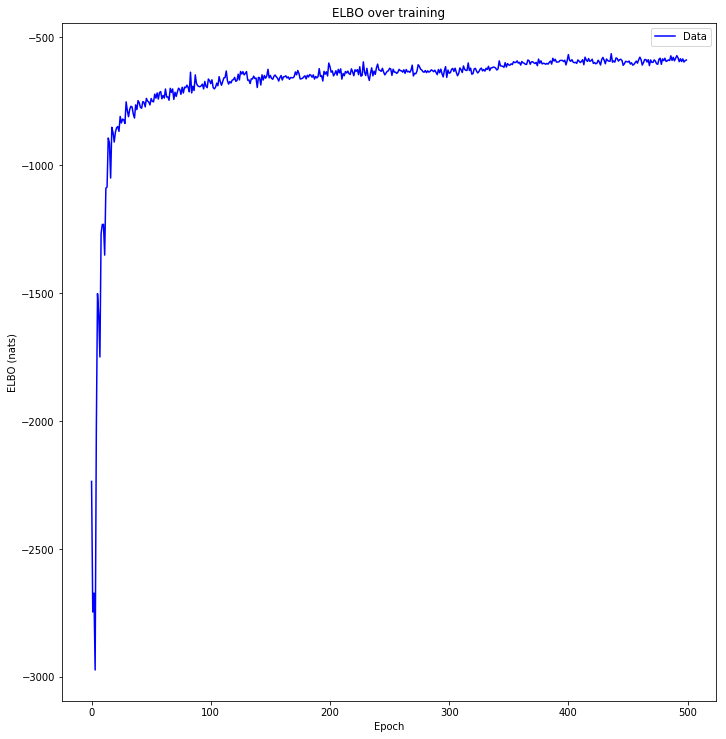

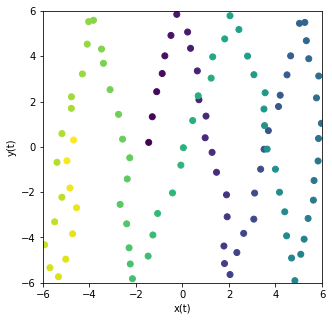

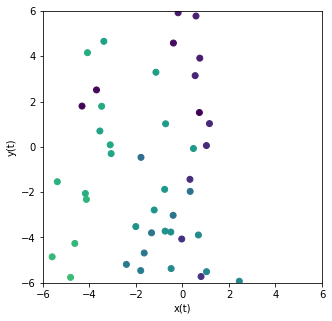

In [20]:
modal_directions = torch.zeros(num_series, K, 2)

for s in range(num_series):
    trajectory, displacements, data = generate_trajectory_trace(s)

    importance_sampler = training_model()
    
    inference, trained_params, elbos = importance.variational_importance(
        importance_sampler, 500, data,
        use_cuda=False, lr=1e-1, inclusive_kl=False,
        patience=100,
    )
    utils.plot_evidence_bounds(elbos, True)
    
    bouncing_ball_posterior = mcmc.reduce_resample_move_smc(importance_sampler.folder.operator, lambda: range(T),
                                                            initializer=importance_sampler.folder._initializer, moves=5)
    (dynamics, position), inference, _ = bouncing_ball_posterior(data=data)
    inferred_trajectory = accumulate_trajectory(inference)
    
    positions = inferred_trajectory.mean(dim=0).cpu().detach()
    displacements = torch.stack([inference['Reduce/Foldable(%d)/StepBallDynamics' % t]['velocity_%d' % t].value.mean(dim=0) for t in range(T)], dim=0).cpu().detach()
    step_numbers = torch.stack((torch.arange(T), torch.arange(T) + 1), dim=-1)
    velocity_srcs = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements), displacements[:-1]), dim=1)
    velocity_dests = torch.cat((torch.arange(T-1).unsqueeze(1).to(displacements) + 1, displacements[1:]), dim=1)
    velocity_steps = torch.stack((velocity_srcs, velocity_dests), dim=1)
    
    graph_original_trajectory(trajectory, T, s)
    graph_inferred_trajectory(positions, T, s)
    graph_displacement_trajectories(velocity_steps, displacements, T, s)
    
    plt.close('all')

In [21]:
trained_params

"{'dynamics__loc': 'tensor([[ 0.0705, -0.0873,  0.0143],\n        [-0.0167, -0.0362,  0.1764]], grad_fn=<CloneBackward>)', 'dynamics__scale': 'tensor([[-1.6246, -2.7335, -1.5768],\n        [-2.4250, -2.3888, -1.3931]], grad_fn=<CloneBackward>)', 'noises__loc': 'tensor([[[ 1.1448,  0.0613],\n         [-0.1928,  1.1449]],\n\n        [[ 0.5951, -0.0216],\n         [ 0.0468,  0.7426]],\n\n        [[ 0.6435, -0.1182],\n         [ 0.0658,  1.2876]],\n\n        [[ 0.5899,  0.0511],\n         [ 0.1793,  0.8146]],\n\n        [[ 0.4792,  0.0107],\n         [-0.0446,  0.5446]],\n\n        [[ 0.8066, -0.1178],\n         [ 0.0410,  0.6069]],\n\n        [[ 0.4631, -0.0946],\n         [ 0.0878,  0.8103]],\n\n        [[ 0.4182,  0.1854],\n         [-0.0608,  0.8614]],\n\n        [[ 0.5510,  0.2860],\n         [ 0.0021,  0.8277]],\n\n        [[ 0.8042, -0.0496],\n         [-0.1006,  0.7909]],\n\n        [[ 0.4329,  0.0191],\n         [ 0.0877,  0.5377]],\n\n        [[ 0.6398,  0.0472],\n         [ 0.07

In [22]:
for t in range(T+1):
    print('Position at time %d' % t, data['position_%d' % t])

Position at time 0 tensor([-1.4512,  0.1990])
Position at time 1 tensor([-1.2972,  1.3310])
Position at time 2 tensor([-1.1078,  2.4381])
Position at time 3 tensor([-0.8703,  3.2395])
Position at time 4 tensor([-0.7568,  4.0195])
Position at time 5 tensor([-0.4945,  4.9223])
Position at time 6 tensor([-0.2430,  5.8520])
Position at time 7 tensor([0.2220, 5.0718])
Position at time 8 tensor([0.3486, 4.3533])
Position at time 9 tensor([0.6399, 3.3553])
Position at time 10 tensor([0.7094, 2.0825])
Position at time 11 tensor([1.0132, 1.3601])
Position at time 12 tensor([0.9768, 0.4034])
Position at time 13 tensor([ 1.2745, -0.2418])
Position at time 14 tensor([ 1.4658, -1.1204])
Position at time 15 tensor([ 1.8950, -2.1155])
Position at time 16 tensor([ 1.9234, -3.0843])
Position at time 17 tensor([ 1.7839, -4.3761])
Position at time 18 tensor([ 1.8093, -5.1501])
Position at time 19 tensor([ 2.0464, -5.6353])
Position at time 20 tensor([ 2.3404, -4.6639])
Position at time 21 tensor([ 2.6331

In [23]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])

Inferred position at time 0 tensor([0.7278, 1.5180])
Inferred position at time 1 tensor([-4.3194,  1.8024])
Inferred position at time 2 tensor([-3.6970,  2.5160])
Inferred position at time 3 tensor([-0.3891,  4.5856])
Inferred position at time 4 tensor([-0.2613,  6.3411])
Inferred position at time 5 tensor([0.0599, 7.9004])
Inferred position at time 6 tensor([0.7221, 6.8141])
Inferred position at time 7 tensor([-0.1870,  5.9222])
Inferred position at time 8 tensor([0.7453, 3.9186])
Inferred position at time 9 tensor([0.5820, 5.7783])
Inferred position at time 10 tensor([0.5463, 3.1465])
Inferred position at time 11 tensor([1.1619, 1.0287])
Inferred position at time 12 tensor([1.0309, 0.0597])
Inferred position at time 13 tensor([ 0.3227, -1.4316])
Inferred position at time 14 tensor([-0.0304, -4.0666])
Inferred position at time 15 tensor([ 0.8002, -5.7226])
Inferred position at time 16 tensor([ 1.3541, -7.9489])
Inferred position at time 17 tensor([ 1.8165, -9.5212])
Inferred position 

In [24]:
bouncing_ball_smc = importance.reduce_smc(importance_sampler.folder.operator, lambda: range(T), initializer=importance_sampler.folder._initializer)
(dynamics, position), inference, _ = bouncing_ball_smc(data=data)
inferred_trajectory = accumulate_trajectory(inference)
positions = inferred_trajectory.mean(dim=0).cpu().detach()

In [25]:
for t in range(T+1):
    print('Inferred position at time %d' % t, positions[t])

Inferred position at time 0 tensor([-0.2120,  1.2034])
Inferred position at time 1 tensor([-0.3478,  1.8461])
Inferred position at time 2 tensor([-0.3791,  2.2122])
Inferred position at time 3 tensor([0.1927, 3.3164])
Inferred position at time 4 tensor([0.4031, 3.0607])
Inferred position at time 5 tensor([0.9092, 3.8117])
Inferred position at time 6 tensor([0.5545, 5.1235])
Inferred position at time 7 tensor([0.8276, 4.7401])
Inferred position at time 8 tensor([0.4854, 5.8998])
Inferred position at time 9 tensor([0.5971, 5.2280])
Inferred position at time 10 tensor([0.2148, 4.4532])
Inferred position at time 11 tensor([0.6505, 3.8051])
Inferred position at time 12 tensor([1.0025, 3.0111])
Inferred position at time 13 tensor([2.4043, 4.3820])
Inferred position at time 14 tensor([2.9246, 4.0283])
Inferred position at time 15 tensor([3.8087, 3.0424])
Inferred position at time 16 tensor([3.7309, 1.5060])
Inferred position at time 17 tensor([3.6383, 0.5780])
Inferred position at time 18 ten

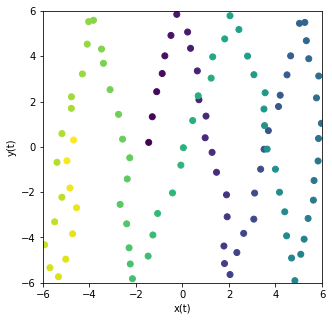

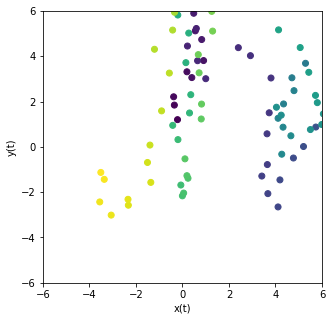

In [26]:
graph_original_trajectory(trajectory, T, s)
graph_inferred_trajectory(positions, T, s)